In [1]:
import sys
if not '..' in sys.path:
    sys.path.append('..')

In [2]:
from pathlib import Path
from analysis import collection, analysis
import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
%matplotlib inline

In [3]:
collection_name = "emg_olympics"
subject_names = collection.get_subject_names(collection_name)
print(f"{len(subject_names)} subjects in {collection_name}.")
c = collection.Collection(collection_name)

46 subjects in emg_olympics.


### counting numbers of hits

In [4]:
# count the number of hits over all sessions for each subject in the collection
hit_counts = {}
for name, sub in c.subjects.items():
    t = sub.tasks["center_hold"]
    sessions = t.sorted_sessions()
    hit_counts[name] = [s.outcome_counts for s in sessions]

In [5]:
# count total number of hits per subject

hit_sums = {}
for subject_name in hit_counts.keys():
    hit_sums[subject_name] = sum([sesh["hits"] for sesh in hit_counts[subject_name]])

sorted_hit_sums = sorted(hit_sums.items(), key = lambda e: e[1])

most_hit_subject = sorted_hit_sums[-1][0]
most_hits = sorted_hit_sums[-1][1]

least_hit_subject = sorted_hit_sums[0][0]
least_hits = sorted_hit_sums[0][1]

median_hit_subject = sorted_hit_sums[len(sorted_hit_sums)//2][0]
median_hits = sorted_hit_sums[len(sorted_hit_sums)//2][1]

print(most_hit_subject, most_hits)
print(median_hit_subject, median_hits)
print(least_hit_subject, least_hits)

# morio 524
# holly 412
# hyewon 212

morio 524
holly 412
hyewon 212


### plot hits, misses, no-holds over sessions

In [16]:
# someone has 18 no holds? that can't be correct?
for sub in hit_counts.keys():
    # print(sub, np.max([h["noholds"] for h in hit_counts[sub]]), np.argmax([h["noholds"] for h in hit_counts[sub]]))
    print(sub, len([h["noholds"] for h in hit_counts[sub]]))

aeron 45
alba 45
andrei 45
andy 45
april 45
arthur 45
billy 45
bob 45
chiyu 45
clem 45
dammy 45
daniel 45
egzona 45
elena 45
emmett 45
fede 45
georgia 45
hernando 45
holly 45
hyewon 45
ivana 45
jai 45
jesse 45
lara 45
lars 45
lucas 45
marta 45
mattias 45
miranda 45
morio 45
nate 45
nicole 45
oriol 45
peterg 45
peterv 45
philip 45
quentin 45
rodrigo 45
sarah 45
svenja 45
tiago 45
tom 45
viktor 45
will 45
zane 45
zeynib 45


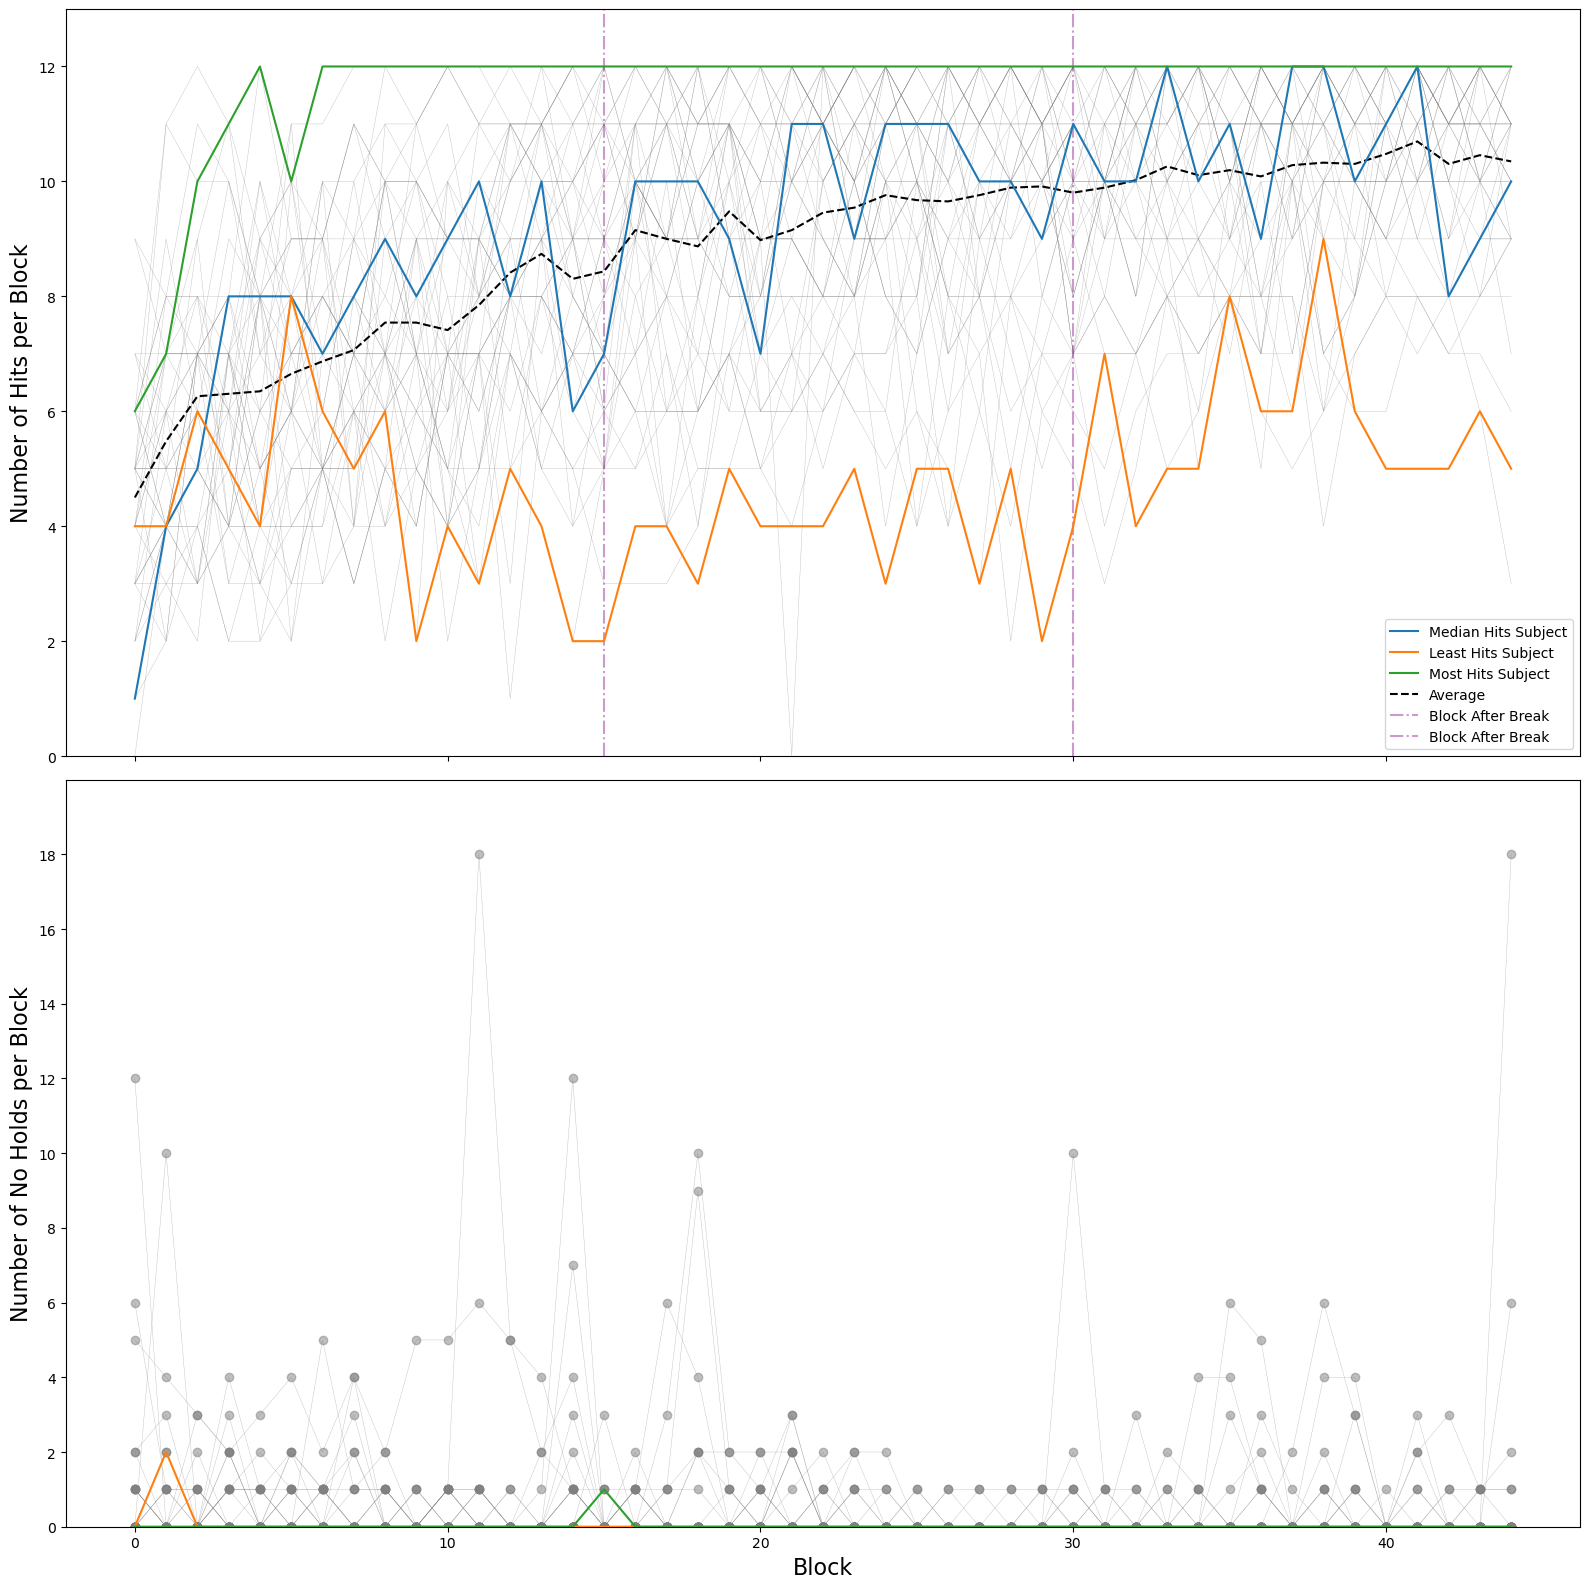

In [24]:
outcomes_fig, (hit_ax, nohold_ax) = plt.subplots(2,1,figsize=(16,16),sharex=True)
hit_sum = np.zeros((45))
for sub in hit_counts.keys():
    hit_vec = np.array([h["hits"] for h in hit_counts[sub]][:45])
    no_hold_vec = np.array([h["noholds"] for h in hit_counts[sub]][:45])
    hit_sum = np.add(hit_sum, hit_vec)
    if sub == most_hit_subject:
        hit_ax.plot(hit_vec,label="Most Hits Subject",zorder=100)
        # miss_ax.plot([h["misses"]/12*100 for h in hit_counts[sub]][:45],zorder=100)
        nohold_ax.plot(no_hold_vec,zorder=100)
    elif sub == median_hit_subject:
        hit_ax.plot(hit_vec,label="Median Hits Subject",zorder=100)
        # miss_ax.plot([h["misses"]/12*100 for h in hit_counts[sub]][:45],zorder=100)
        nohold_ax.plot(no_hold_vec,zorder=100)
    elif sub == least_hit_subject:
        hit_ax.plot(hit_vec,label="Least Hits Subject",zorder=100)
        # miss_ax.plot([h["misses"]/12*100 for h in hit_counts[sub]][:45],zorder=100)
        nohold_ax.plot(no_hold_vec,zorder=100)
    else:
        hit_ax.plot(hit_vec, "grey", linewidth=0.3,alpha=0.5)
        # miss_ax.plot([h["misses"]/12*100 for h in hit_counts[sub]][:45], "grey", linewidth=0.3,alpha=0.2)
        nohold_ax.plot(no_hold_vec, "-o", c="grey", linewidth=0.3,alpha=0.5)

hit_avg = np.divide(hit_sum, len(hit_counts.keys()))
hit_ax.plot(hit_avg, "k--", label="Average")

# hit_ax.set_title("Hits over Blocks", fontsize=16)
hit_ax.set_ylim([0,13])
hit_ax.set_ylabel("Number of Hits per Block", fontsize=16)
# add lines for subjects taking a rest
hit_ax.plot([15, 15], hit_ax.get_ylim(), "-.", c="purple", alpha=0.4, label="Block After Break")
hit_ax.plot([30, 30], hit_ax.get_ylim(), "-.", c="purple", alpha=0.4, label="Block After Break")
hit_ax.legend(loc="lower right")

# # miss_ax.set_title("Misses over Blocks", fontsize=16)
# miss_ax.set_ylim([0,105])
# miss_ax.set_ylabel("Miss Percentage [%]", fontsize=16)

# nohold_ax.set_title("No Holds over Blocks", fontsize=16)
nohold_ax.set_ylabel("Number of No Holds per Block", fontsize=16)
nohold_ax.set_ylim([0,20])
nohold_ax.set_yticks(list(range(0,20,2)))
nohold_ax.set_xlabel("Block", fontsize=16)


outcomes_fig.tight_layout()

In [ ]:
outcomes_fig.savefig("/Users/spencer/motor-control/thesis/images/data_analysis2023/outcomes.pdf", dpi=300, format="pdf")

## hit percentages per target

In [25]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

        def draw(self, renderer):
            """ Draw. If frame is polygon, make gridlines polygon-shaped """
            if frame == 'polygon':
                gridlines = self.yaxis.get_gridlines()
                for gl in gridlines:
                    gl.get_path()._interpolation_steps = num_vars
            super().draw(renderer)


        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)


                return {'polar': spine}
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

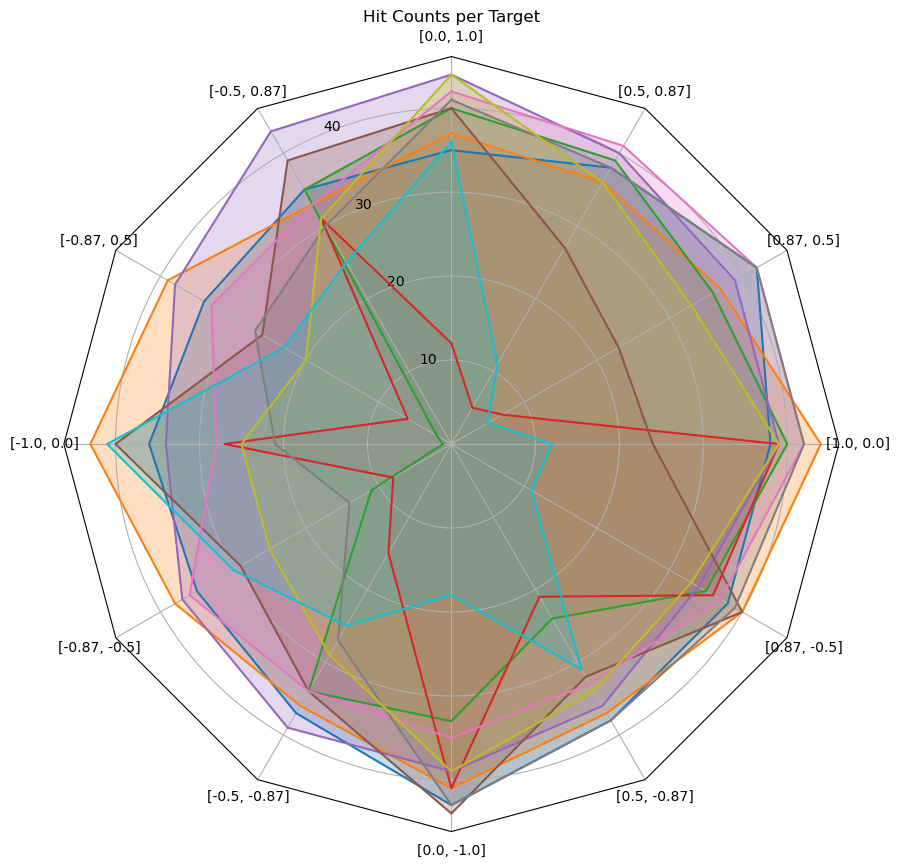

In [31]:
data = []
for subject in c.alphabetically_sorted_subjects():
    sessions  = subject.tasks["center_hold"].sorted_sessions()
    hit_counts_per_target = {}
    for sesh in sessions:
        trials = sesh.sorted_trials()
        for trial in trials:
            # get outcome
            oc = trial.outcome
            if oc == "Hit":
                # get target location
                try:
                    current_count = hit_counts_per_target[str(trial.target_coords)][1]
                    hit_counts_per_target[str(trial.target_coords)] = (trial.target_coords, current_count+1)
                except KeyError:
                    hit_counts_per_target[str(trial.target_coords)] = (trial.target_coords, 0)
    target_names = []
    counts = []
    # sort by theta angle
    for name, (coord, count) in sorted(hit_counts_per_target.items(), key=lambda s: np.arctan2(s[1][0][1],s[1][0][0])):
        target_names.append(name)
        counts.append(count)
    data.append(counts)


N = len(target_names)
theta = radar_factory(N, frame='polygon')

# roll these around to line up with plot coordinates
rollby=-8
spoke_labels = np.roll(np.array(target_names), rollby)
title = "Hit Counts per Target"

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='radar'))
fig.subplots_adjust(top=0.85, bottom=0.05)

ax.set_rgrids([10, 20, 30, 40, 50, 60])
ax.set_title(title,  position=(0.5, 1.1), ha='center')

for d in data[-10:]:
    d = np.roll(np.array(d), rollby)
    line = ax.plot(theta, d)
    ax.fill(theta, d,  alpha=0.25)
ax.set_varlabels(spoke_labels)

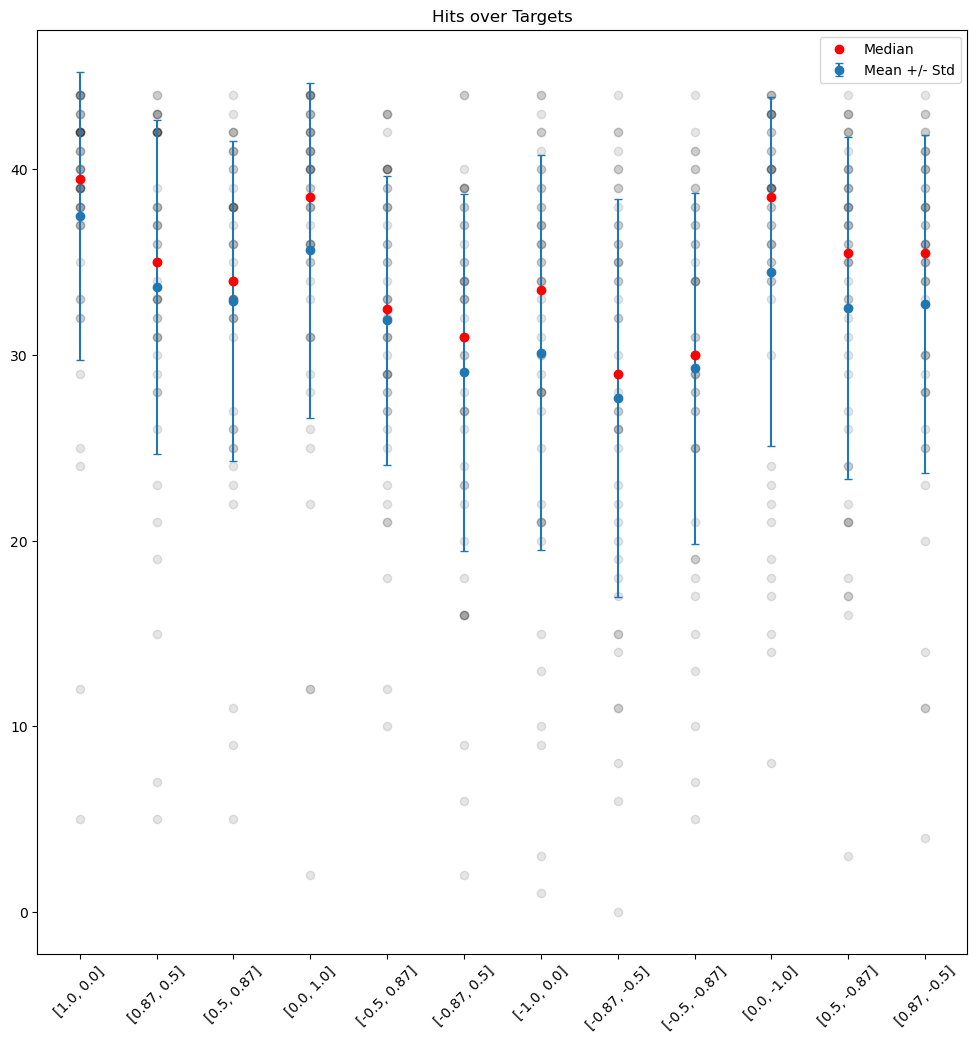

In [29]:
rollby = 7
fig, ax = plt.subplots(1,1,figsize=(12,12))
for d in data:
    ax.plot(np.roll(d, rollby), 'ko', alpha=0.1)
ax.set_xticks(range(len(target_names)))
ax.set_xticklabels(np.roll(target_names, rollby), rotation=45)

means = np.mean(data,axis=0)
medians = np.median(data,axis=0)
stds = np.std(data,axis=0)
ax.errorbar(np.roll(target_names, rollby), np.roll(means, rollby), np.roll(stds, rollby), linestyle='None', marker='o', capsize=3, label="Mean +/- Std")
ax.plot(np.roll(target_names, rollby), np.roll(medians, rollby), 'ro', label="Median")
ax.set_title("Hits over Targets")
ax.legend()

## plot and fit the hit reach times

In [32]:
def avg(l):
    if len(l) == 0:
        return None
    else:
        return sum(l)/len(l)

def drop_nones(l, return_indices=False):
    new_l = []
    enum = []
    for i, e in enumerate(l):
        if not e is None:
            new_l.append(e)
            enum.append(i)
    if return_indices:
        return enum, new_l
    else:
        return new_l

In [33]:
# average "Hit" reach time per session over subjects
avg_reach_times = {}
for sub in c.subjects.values():
    avg_reach_times[sub.name] = []
    for session in sorted(list(sub.tasks["center_hold"].sessions.values()),key=lambda s: s.number):
        sorted_trials = sorted(list(session.trials.values()), key=lambda d: d.number)
        # mean hit reach time over trials in a session
        avg_reach_times[sub.name].append(avg([t.reach_time for t in sorted_trials if t.outcome == "Hit"]))

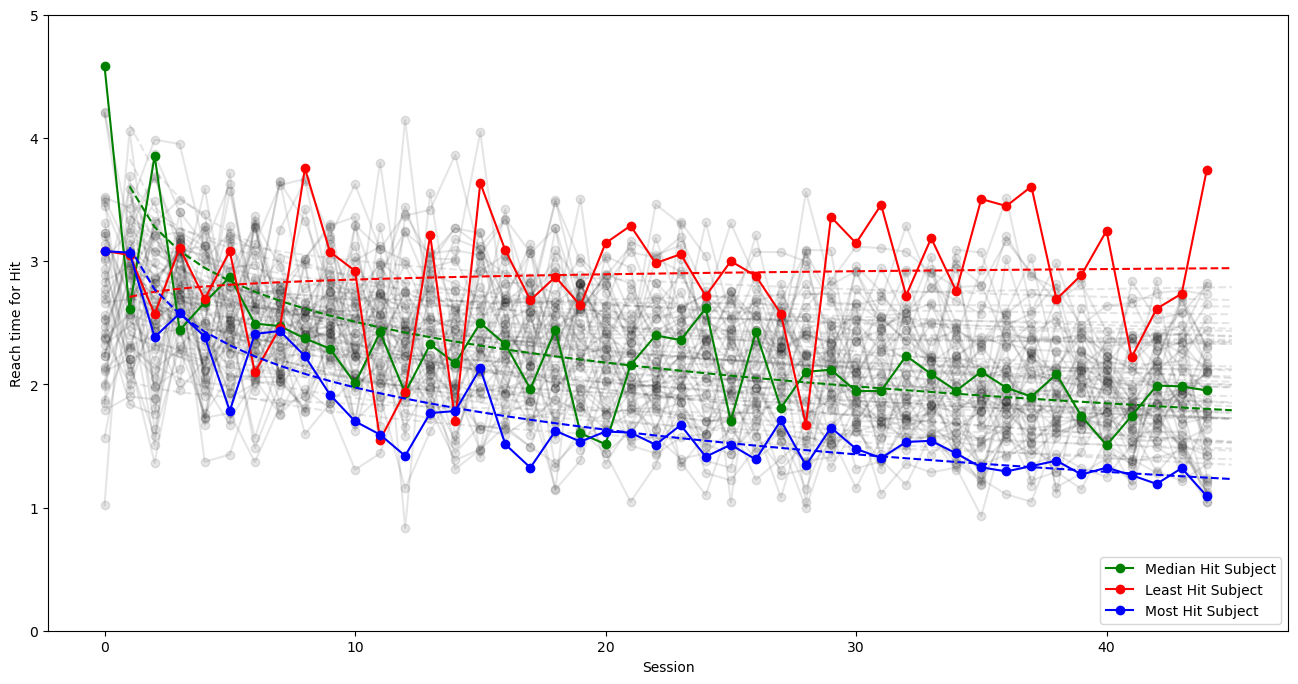

In [53]:
learning_rates = {}
fig, ax = plt.subplots(1,1, figsize=[16,8])
for s in c.subjects.values():
    t = avg_reach_times[s.name]
    x, y = drop_nones(t, return_indices=True)
    x = [xx+1 for xx in x]
    params = curve_fit(analysis.log, x, y)[0]
    learning_rates[s.name] = params[1]
    if s.name == most_hit_subject:
        ax.plot(t,'-o', c="blue", zorder=100, label="Most Hit Subject")
        ax.plot(x, analysis.log(x, params[0], params[1]), "--", c="blue", zorder=100)
    elif s.name == median_hit_subject:
        ax.plot(t,'-o', c="green", zorder=100, label="Median Hit Subject")
        ax.plot(x, analysis.log(x, params[0], params[1]), "--", c="green", zorder=100)
    elif s.name == least_hit_subject:
        ax.plot(t,'-o', c="red",zorder=100, label="Least Hit Subject")
        ax.plot(x, analysis.log(x, params[0], params[1]), "--", c="red",zorder=100)
    else:
        ax.plot(t,'k-o', alpha=0.1)
        ax.plot(x, analysis.log(x, params[0], params[1]), "--", c='k', alpha=0.1)
ax.set_ylim([0,5])
ax.set_ylabel("Reach time for Hit")
ax.set_xlabel("Session")
ax.legend(loc="lower right")


(-1.0, 1.0)

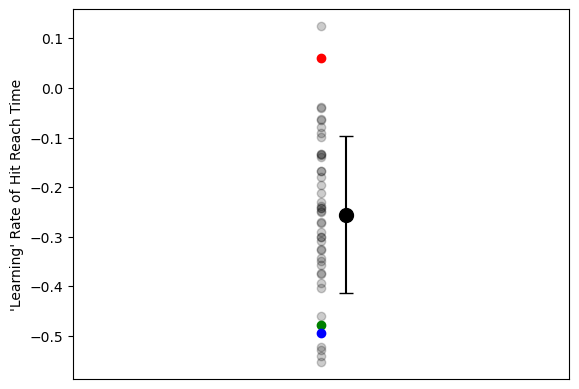

In [89]:
for name, lr in list(learning_rates.items()):
    if name == most_hit_subject:
        plt.plot(0, lr, "o", c='blue', zorder=100, label="Most Hit Subject")
    elif name == median_hit_subject:
        plt.plot(0, lr, "o", c='green', zorder=100, label="Median Hit Subject")
    elif name == least_hit_subject:
        plt.plot(0, lr, "o", c='red', zorder=100, label="Least Hit Subject")
    else:
        plt.plot(0,lr,'ko',alpha=0.2)
plt.ylabel("'Learning' Rate of Hit Reach Time")
plt.xticks([])

lr_list = list(learning_rates.values())
plt.plot(0.1, np.mean(lr_list), "ko", markersize=10)
plt.errorbar(0.1, np.mean(lr_list), yerr=np.std(lr_list), markersize=10, c="k", capsize=5)
plt.xlim([-1,1])

# trajectory ~~path length~~ velocity over trials

In [83]:
def path_length(a):
    assert a.shape[0] > a.shape[1], f"array with shape {a.shape} should be transposed."
    assert a.shape[1] == 2, f"array with shape {a.shape} must be two-dimensional"
    return np.sum(np.sqrt(np.sum(np.diff(a, axis=0)**2,axis=1)))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

egzona session_25 trial_12
georgia session_30 trial_12
jesse session_24 trial_12


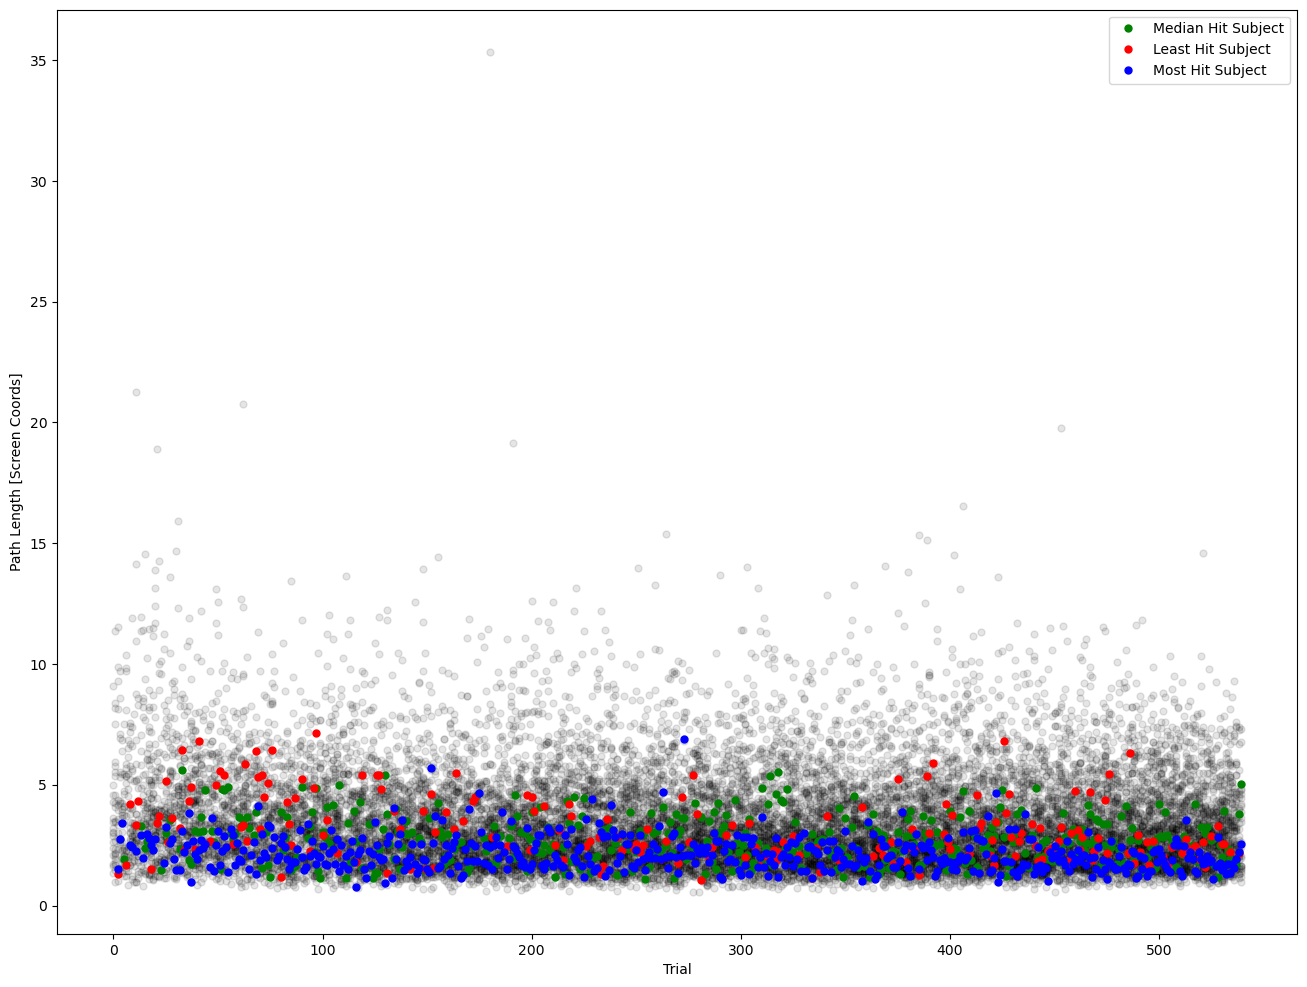

In [112]:
# TODO
# - add an average plot here, tricky because of mismatched numbers of trials for some subjects-- fix this by finding "dropped" trials and ignoring them with Nones

sample_rate = 200 # samples / sec
reaction_time_delay = 50 # samples == 50 samples / 200Hz = 250ms 

plt.figure(figsize=(16,12))
# path lengths per trial over subjects
for sub in c.subjects.values():
    normalized_lengths = []
    for session in sub.tasks["center_hold"].sorted_sessions():
        sorted_trials = session.sorted_trials()
        for t in sorted_trials:
            # only look at Hit trials
            if t.outcome == "Hit":
                traj = t.get_trajectory()
                # path length of movement time / reach time -- basically average velocity
                movement_portion = traj[(int(np.ceil(t.hold_time*sample_rate)) + reaction_time_delay):,-2:]
                # not sure what's going on here?
                if movement_portion.shape[0] == 0:
                    print(sub.name, session.name, trial.name)
                    normalized_lengths.append(None)
                    continue
                pl = path_length(movement_portion)
                normalized_lengths.append(pl / t.reach_time)
            elif t.outcome=="Miss":
                normalized_lengths.append(None)
    if sub.name == most_hit_subject:
        plt.plot(normalized_lengths,'o', c="blue", label="Most Hit Subject", zorder=100, markersize=5)
    elif sub.name == median_hit_subject:
        plt.plot(normalized_lengths,'o', c="green", label="Median Hit Subject", zorder=100, markersize=5)
    elif sub.name == least_hit_subject:
        plt.plot(normalized_lengths,'o', c="red", label="Least Hit Subject", zorder=100, markersize=5)
    else:
        plt.plot(normalized_lengths,'ko',alpha=0.1, markersize=5)

    plt.xlabel("Trial")
    plt.ylabel("Path Length [Screen Coords]")
    plt.legend(loc="upper right")
    

Seems like average velocity goes down over trials for hits! Interesting. 

# trajectory segments over trials

In [113]:
def get_zero_crossings(x):
    # find the indices where the velocity of the trajectory changes sign
    assert len(x.shape) == 1
    return np.where(np.diff(np.sign(np.diff(x))))[0]

def get_segment_indices(t, hold_steps, velocity_threshold_percentage=6, min_crossing_interval=8):
    assert t.shape[1] == 2, f"trajectory has incorrect shape: {t.shape}"
    zero_crosses_x = get_zero_crossings(t[:,0])
    zero_crosses_y = get_zero_crossings(t[:,1])
    # combine vx and vy together
    zero_crosses_xy = np.concatenate((zero_crosses_x, zero_crosses_y))
    # sort the x and y indices
    zero_crosses_xy.sort()
    zc_clean = []
    vel_lim = np.max(np.abs(t))*(velocity_threshold_percentage/100)
    for i, z in enumerate(zero_crosses_xy[:-1]):
        # ignore anything before hold period
        if z > hold_steps:
            # reject crossing if the neighborhood is low velocity
            if np.max(np.abs(t[z-min([5,z]):z+5, :])) > vel_lim:
                # reject the crossing if it's not spaced out above a threshold
                if abs(z - zero_crosses_xy[i+1]) > min_crossing_interval: 
                    zc_clean.append(z)
    return zc_clean

def sorted_dict_items_by_key(d):
    return [(k, v) for k, v in sorted(d.items(), key= lambda b: b[0])]

In [135]:
reaction_time_delay = 50 # 200 ms?
sample_rate = 200

# hold_time is the time until the target appears (subjects have thus held for 0.75s within a possible 3.5s window)
num_segments = {}
# get sorted subjects
for sub in c.alphabetically_sorted_subjects():
    segment_counts_per_trial = []
    for session in sub.tasks["center_hold"].sorted_sessions():
        for trial in session.sorted_trials():
            # ignore no hold trials
            if trial.outcome == "Hit":
                trial.get_trajectory()
                trajectory = trial.trajectory[:,-2:]
                # time at beginning of trial for holding
                hold_steps = int(np.ceil(trial.hold_time*sample_rate)) + reaction_time_delay
                # find segments
                segment_indices = get_segment_indices(trajectory, hold_steps=hold_steps)
                # count segments
                segment_counts_per_trial.append(len(segment_indices))
            elif trial.outcome == "Miss":
                segment_counts_per_trial.append(None)
    num_segments[sub.name] = segment_counts_per_trial

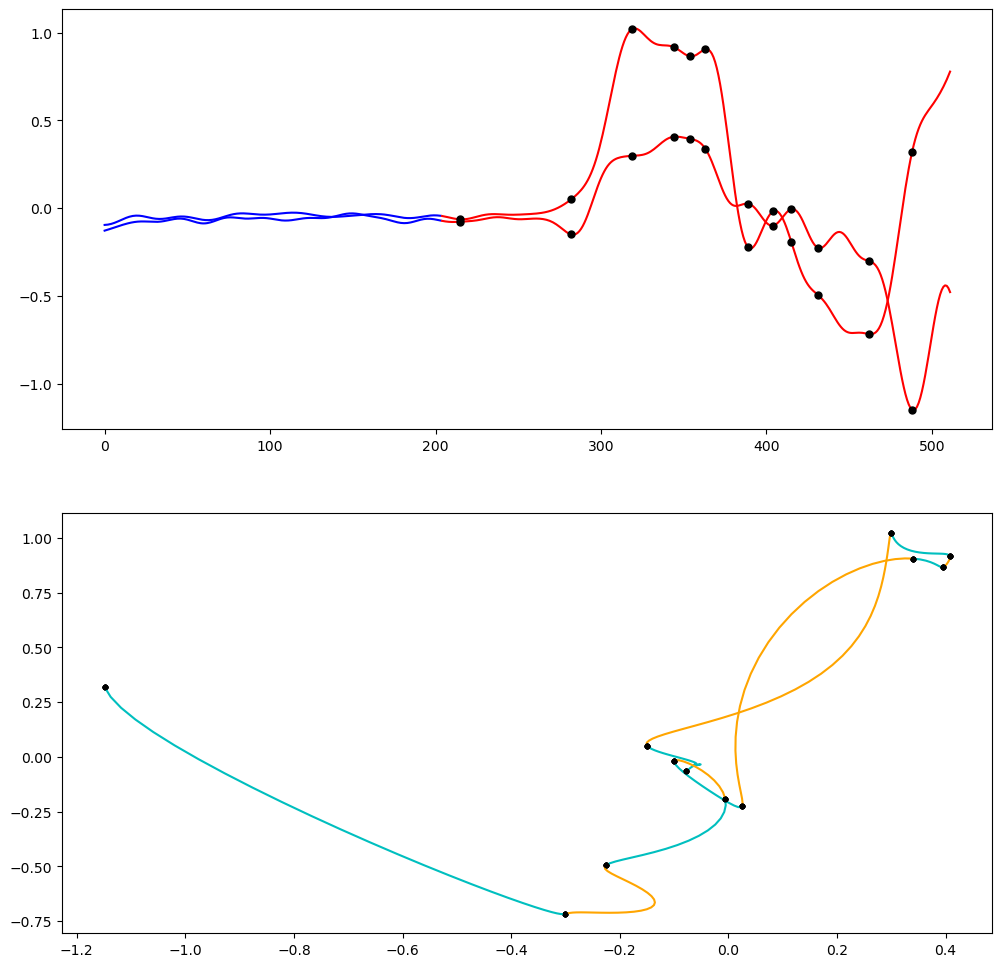

In [136]:
s = c.alphabetically_sorted_subjects()[0]
sesh = s.tasks["center_hold"].sorted_sessions()[10]
t = sesh.sorted_trials()[8]
t.get_trajectory()
trajectory = t.trajectory[:,-2:]
# time at beginning of trial for holding
hold_steps = int(np.ceil(trial.hold_time*sample_rate)) + reaction_time_delay
# find segments
segment_indices = get_segment_indices(trajectory, hold_steps=hold_steps)

fig, axes = plt.subplots(2,1, figsize=(12,12))

# test plot
axes[0].plot(range(hold_steps), trajectory[:hold_steps,0], "b")
axes[0].plot(range(hold_steps, trajectory.shape[0]), trajectory[hold_steps:,0], "r")
axes[0].plot(range(hold_steps), trajectory[:hold_steps,1], "b")
axes[0].plot(range(hold_steps, trajectory.shape[0]), trajectory[hold_steps:,1], "r")
axes[0].plot(segment_indices, trajectory[segment_indices,0], "ko",markersize=5)
axes[0].plot(segment_indices, trajectory[segment_indices,1], "ko",markersize=5)

color = "orange"
for i, zc in enumerate(segment_indices[:-1]):
    if color == "orange":
        color = "c"
    else:
        color = "orange"
    axes[1].plot(trajectory[zc:segment_indices[i+1]+1,0],trajectory[zc:segment_indices[i+1]+1,1], c=color)
    axes[1].plot(trajectory[segment_indices,0], trajectory[segment_indices,1], "ko", markersize=3)

In [142]:
[len(v) for v in list(num_segments.values())]

[540,
 540,
 537,
 540,
 540,
 540,
 540,
 540,
 540,
 540,
 540,
 540,
 540,
 540,
 538,
 540,
 537,
 528,
 540,
 540,
 540,
 540,
 538,
 540,
 540,
 539,
 533,
 539,
 540,
 540,
 540,
 540,
 540,
 540,
 540,
 540,
 537,
 540,
 540,
 539,
 533,
 540,
 540,
 540,
 540,
 536]

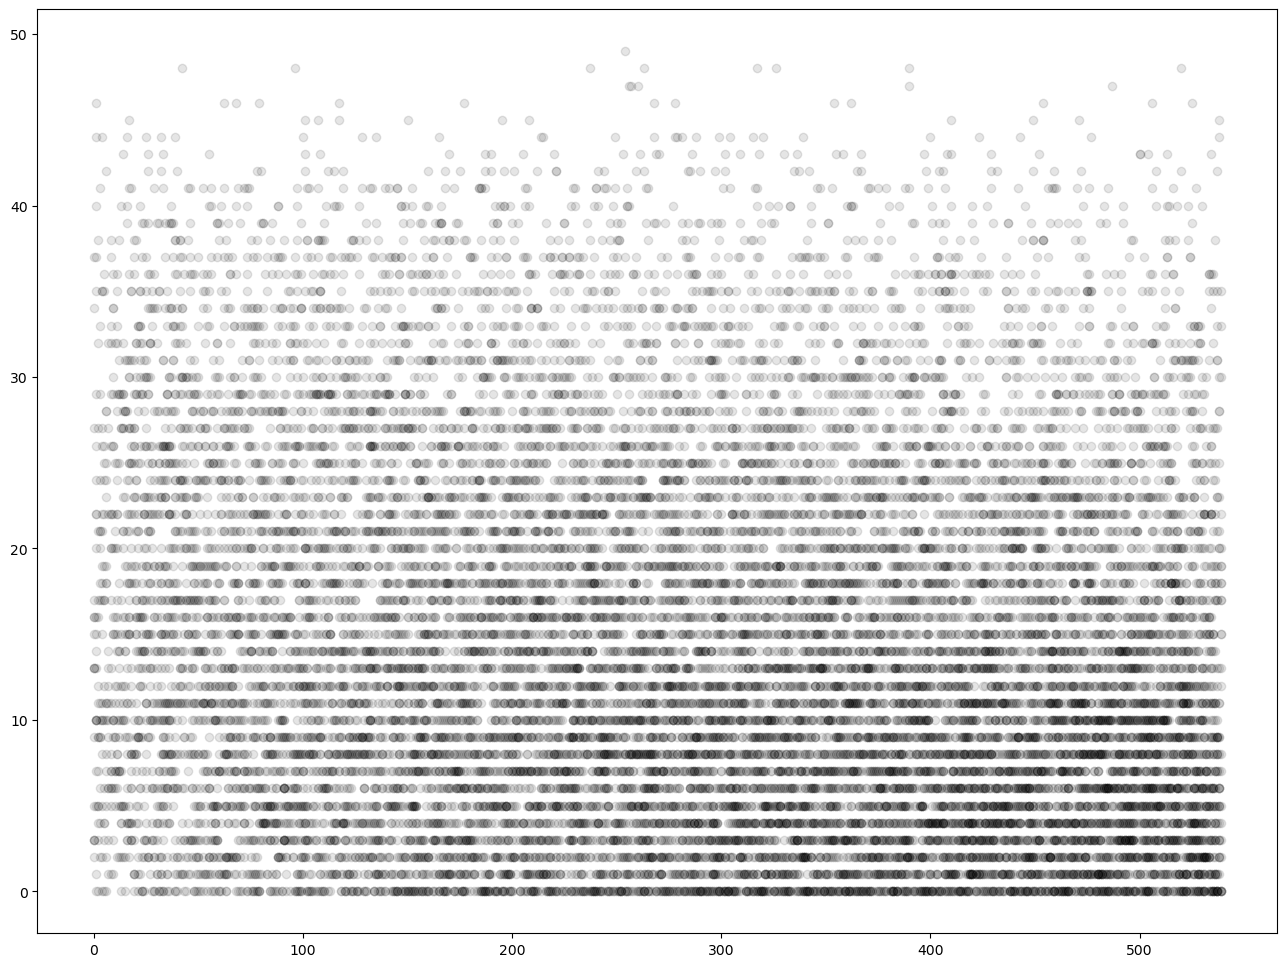

In [141]:
fig, axes = plt.subplots(1,1, figsize=(16,12))
for subject_name, counts in list(num_segments.items()):
    plt.plot(counts, "ko", alpha=0.1)

Seems like by eye there's not much of a trend here. But we can use the segment analysis to understand "corrections" with some work.